In [7]:
from tensorflow import keras
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler

In [8]:
##### Boston_housing dataset #####
# 종속변수는 미국 Boston에 속한 도시들의 70년대 중반 집들의 중간값
# data point는 도시
# 독립변수는 범죄율, 평균 소득 등
# 10 = > $ 10K

In [9]:
# 데이터 불러오기
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape) # (404개의 data points, 13개의 독립변수)

(404, 13)


In [10]:
# 데이터 확인
print(train_data[0])
print(train_targets[:5])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
[15.2 42.3 50.  21.1 17.7]


### 데이터 표준화

In [11]:
scaler = StandardScaler()

In [12]:
### 표준화 방법 1
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data) # fit_transform 사용 X

In [13]:
### 표준화 방법 2
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [14]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

### 회귀분석 적용

In [15]:
# 회귀분석
from sklearn.linear_model import LinearRegression
model_std = LinearRegression()

print(model_std.fit(train_data, train_targets))
print(model_std.score(test_data, test_targets))

LinearRegression()
0.7213535934621551


In [16]:
# Ridge
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=0.5)

print(model_ridge.fit(train_data, train_targets))
print(model_ridge.score(test_data, test_targets))

Ridge(alpha=0.5)
0.721905249867746


In [17]:
# Lasso
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.5)

print(model_lasso.fit(train_data, train_targets))
print(model_lasso.score(test_data, test_targets))

Lasso(alpha=0.5)
0.7379730952910653


### 신경망 사용하기
2개의 은닉층을 갖고, 은닉층 노드의 수는 64인 모델을 사용

독립변수의 수 : 13개 

입력 노드의 수 : 13개 (독립변수와 동일)

입력 층의 노드 개수 : 14개(편향 포함)

은닉층(1번)의 노드 개수 : 65개(64 + 편향 1 )

은닉층(2번)의 노드 개수 : 65개(64 + 편향 1 )

출력층의 노드 개수 : 1개 (회귀)

활성화 함수 : Relu 사용

### Keras

In [18]:
from keras import models
from keras import layers

In [19]:
model = models.Sequential()

# 편항 노드는 자동적으로 1이 추가되어 있어서 별도 추가 필요 X
model.add(layers.Dense(64, input_shape=(train_data.shape[1],)))
model.add(layers.ReLU())
model.add(layers.Dense(64))
model.add(layers.ReLU())
model.add(layers.Dense(1))

2022-10-27 18:06:45.447663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-10-27 18:06:45.448829: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-27 18:06:45.449750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# 기본적인 회귀분석 모형을 사용했으면 14개의 파라미터만이 있었을 것(13 + 1)
# 간단한 신경망을 만들었을 뿐인데도 회귀모형과 비교해서 파라미터가 겁나 많음
# 때문에 신경망을 사용할 경우 과적합의 위험성이 상당히 높다는걸 알 수 있음

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
# optimizer 적용
adam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam, loss='mse')

In [37]:
# batch size에 따라 해당 데이터 끝에 남는 관측치가 생기는데, deeplearning framework에 따라 해당 데이터를 쓸수도 안쓸수도 있음
# 업데이트 횟수 : 404 / 16 
# batch_size = 10, validation_split 이 0.2로 주어질 경우 : 404 * 0.8 / 10 = 32.xxxxx.... = 33 번 계산함
# 매 epoch 마다 관측치 index를 뒤집어가면서 학습을 시킴

history = model.fit(train_data, train_targets, epochs=80, batch_size=10, validation_split=0.2)

Epoch 1/80
33/33 [==============================] - 0s 6ms/step - loss: 530.9036 - val_loss: 535.0509
Epoch 2/80
33/33 [==============================] - 0s 3ms/step - loss: 377.5857 - val_loss: 328.4128
Epoch 3/80
33/33 [==============================] - 0s 3ms/step - loss: 166.4835 - val_loss: 127.2356
Epoch 4/80
33/33 [==============================] - 0s 3ms/step - loss: 68.9611 - val_loss: 75.1889
Epoch 5/80
33/33 [==============================] - 0s 3ms/step - loss: 45.9677 - val_loss: 51.9442
Epoch 6/80
33/33 [==============================] - 0s 4ms/step - loss: 34.4845 - val_loss: 38.4907
Epoch 7/80
33/33 [==============================] - 0s 4ms/step - loss: 27.8297 - val_loss: 31.3050
Epoch 8/80
33/33 [==============================] - 0s 4ms/step - loss: 24.5037 - val_loss: 26.7358
Epoch 9/80
33/33 [==============================] - 0s 4ms/step - loss: 22.2591 - val_loss: 24.0553
Epoch 10/80
33/33 [==============================] - 0s 4ms/step - loss: 20.2485 - val_loss: 2

In [38]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

### Loss 값 변화 살펴보기

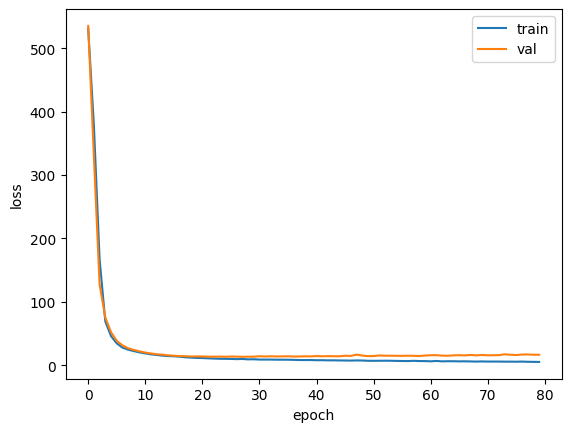

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 모델 평가하기

In [22]:
# test 관측치 102개에 대해 default batch_size = 32 로 계산
y_pred = model.predict(test_data)

4/4 [==============================] - 0s 2ms/step


# 성능 평가하기

In [89]:
from sklearn.metrics import r2_score

r2_score(test_targets, y_pred)

0.8210492169613169